# Ranking AIB Presynaptic Inputs in NeuroPAL Data:
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 10.13.25, last updated: 10.16.25


This code will walk through how we found the top ranking neurons presynaptic to AIB using NeuroPAL data from Yemini et al., Cell 2021. (doi: https://doi.org/10.1016/j.cell.2020.12.012)

Dataset was obtained from their website: https://www.yeminilab.com/neuropal

A README file is provided with their dataset, and was used for guidance. Please familiarize yourself with their dataset and README to better understand the data structures and why I processed data the way I did.

This code will walk through how data was processed, and how top ranking presynaptic inputs were determined based on how well they correlated to AIB activity.

The top ranking sensory neurons we found here were what was used for further modeling in the paper. They will be used in the provided 'Modeling with NeuroPAL Data.ipynb' notebook. Note, we only chose sensory neurons because there weren't too many top ranking interneurons, and we didn't want to cause over-fitting during modeling. The top ranking motor inputs included AVA and RIM, which is what we used for modeling, but it also included other reversal-related inputs, like SAAV. We did some modeling with these inputs, and it seemed like AIB summed these reversal-oriented inputs, since they had correlated activities. These results are unpublished. Feel free to try other modeling combos for yourself! 

Note: in the NeuroPAL dataset, there are traces missing here and there, and there are uneven dataset lengths, or datasets with nans padded randomly. A lot of the processing and modeling has to work around these caveats, so I have to include a lot of loop statements to resolve these issues. I use a lot of 'try-except' loops to help.


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import numpy as np


In [4]:
# There are 3 datasets provided (explained in comments below). 
# I use mat1 and mat3 because they correlate with the same worm (OH16230), 
# and some of the neurons we need are in the tail.

import scipy.io

# change to your pathname :) 
pathname = '/Users/lotus/Desktop/Python/NeuroPAL data/Whole-Brain Calcium Activity/Young Adults/'

mat1 = scipy.io.loadmat(pathname + 'Head_Activity_OH16230.mat')
# 21 Heads, healthier than other strain 
worm_num = 21

mat2 = scipy.io.loadmat(pathname + 'Head_Activity_OH15500.mat')
# 7 Heads

mat3 = scipy.io.loadmat(pathname + 'Tail_Activity_OH16230.mat')
# 21 Tails

print('Data Imported')


Data Imported


/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/h2/nr_g6r3s37v0y4h9l4yjz0bw0000gn/T/ipykernel_51740/475201580.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')


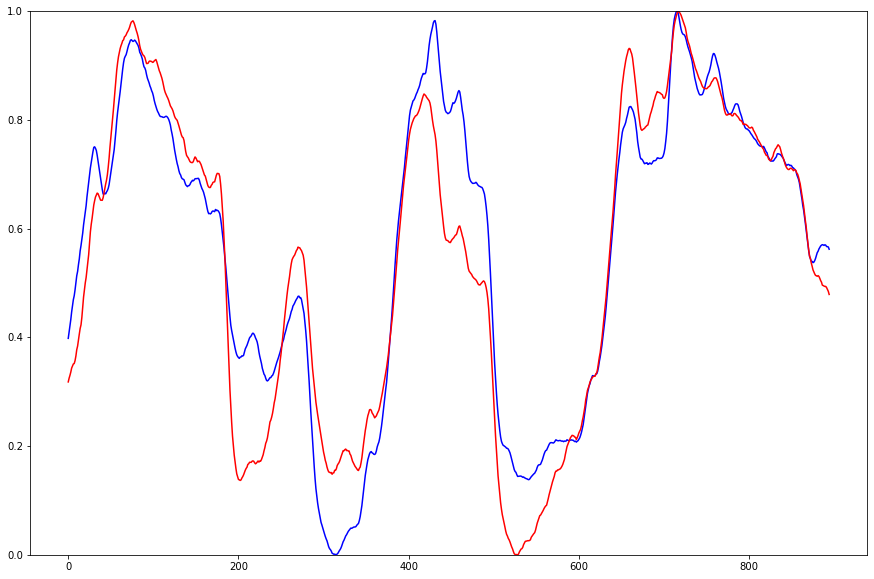

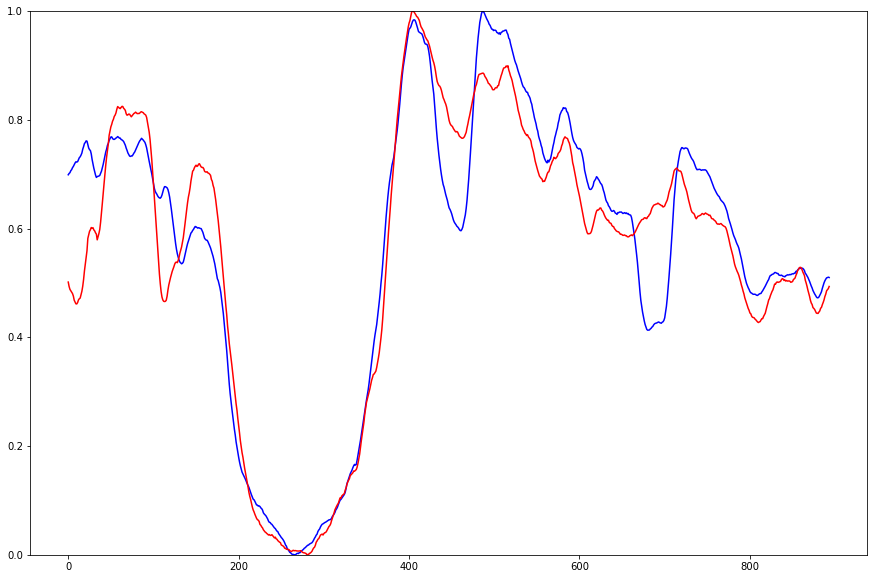

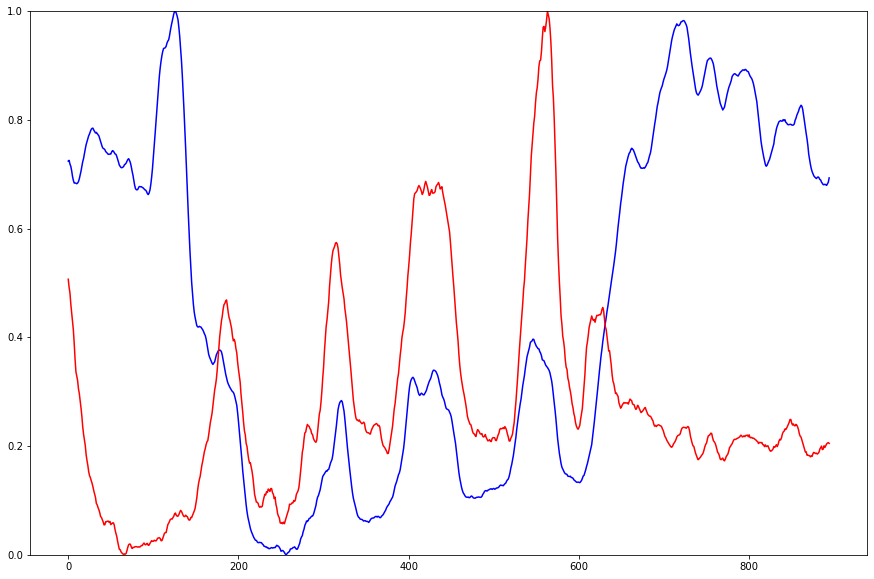

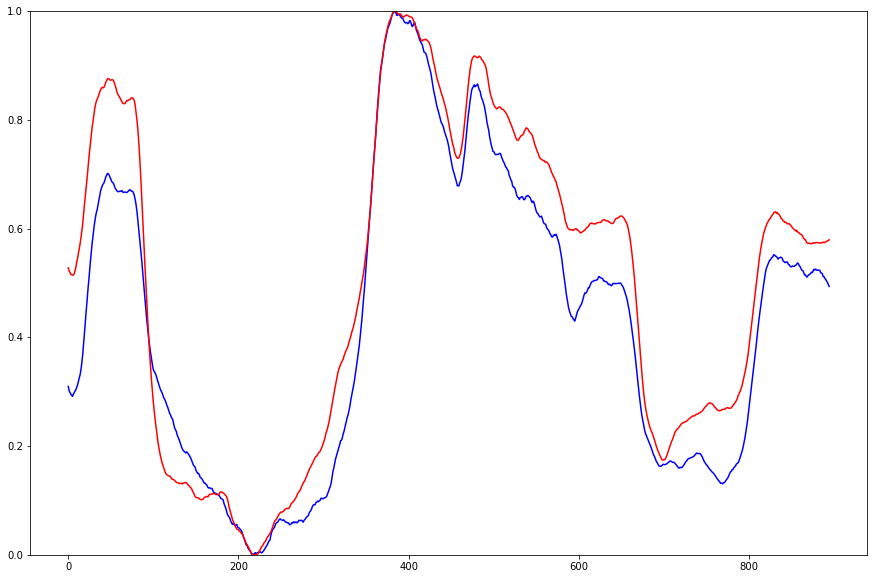

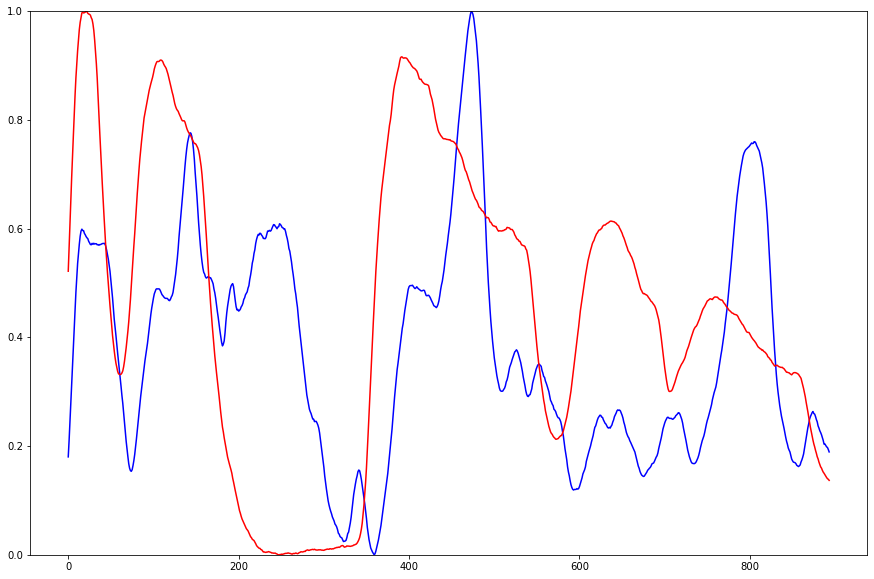

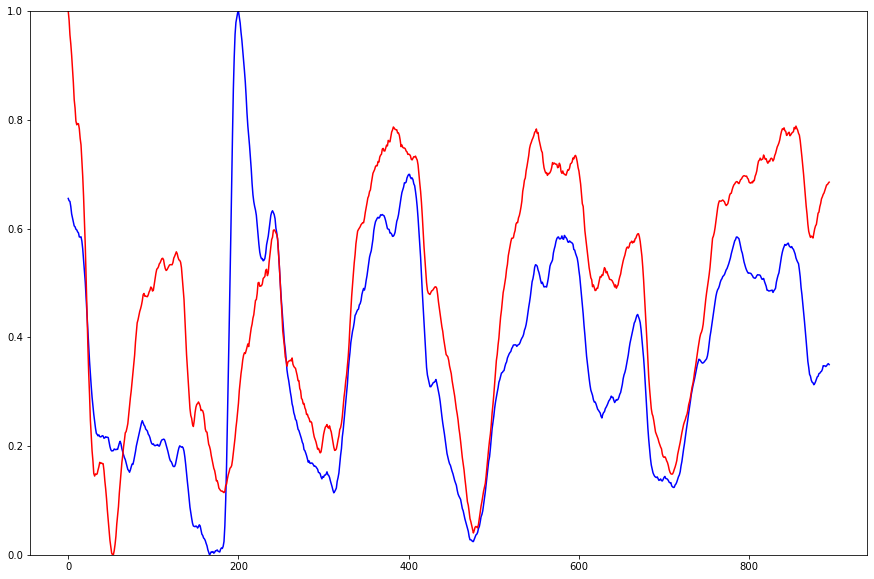

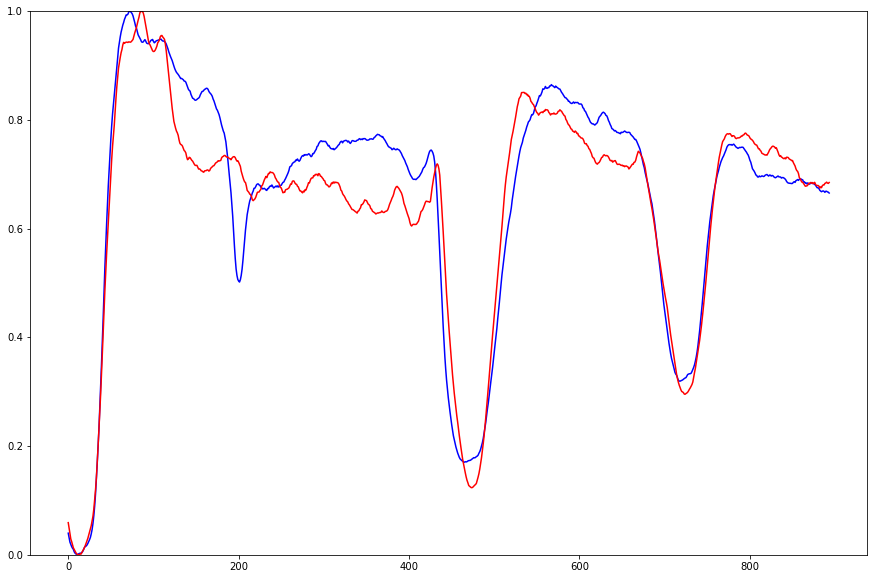

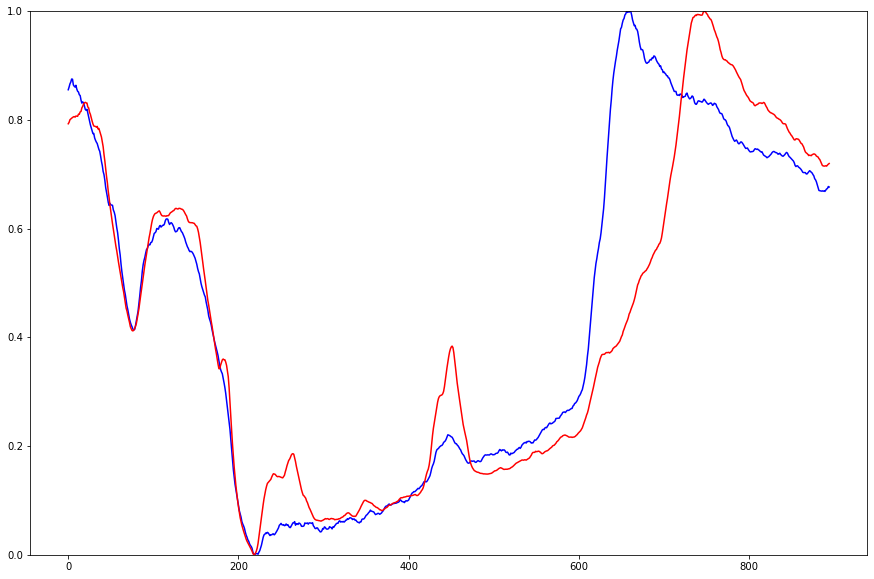

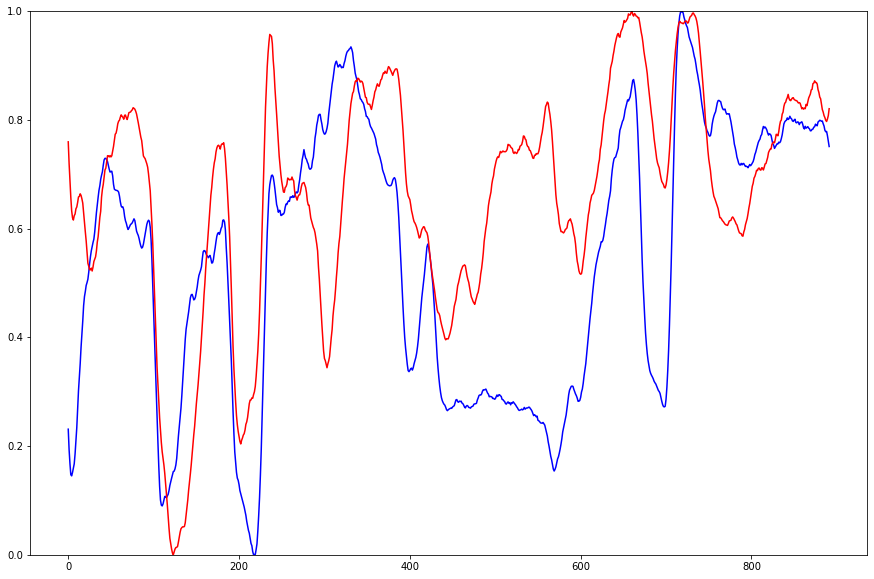

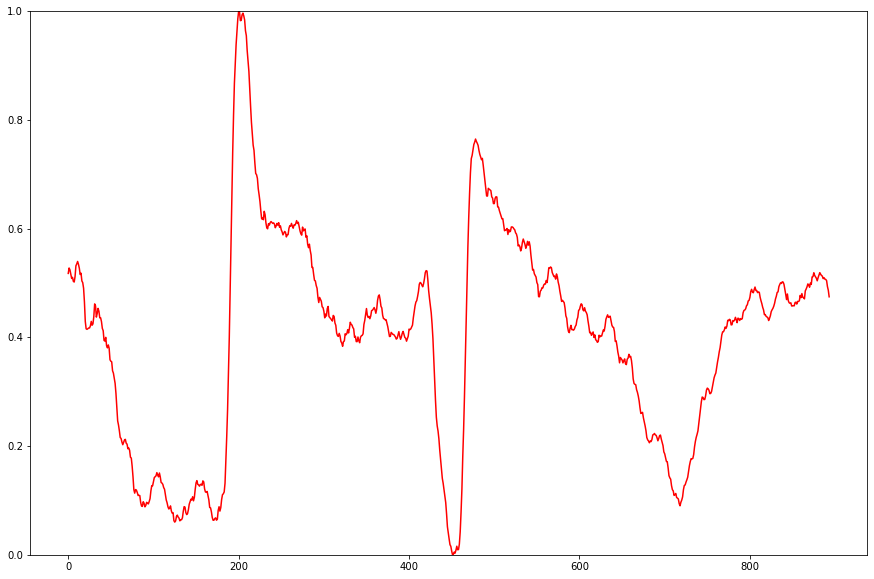

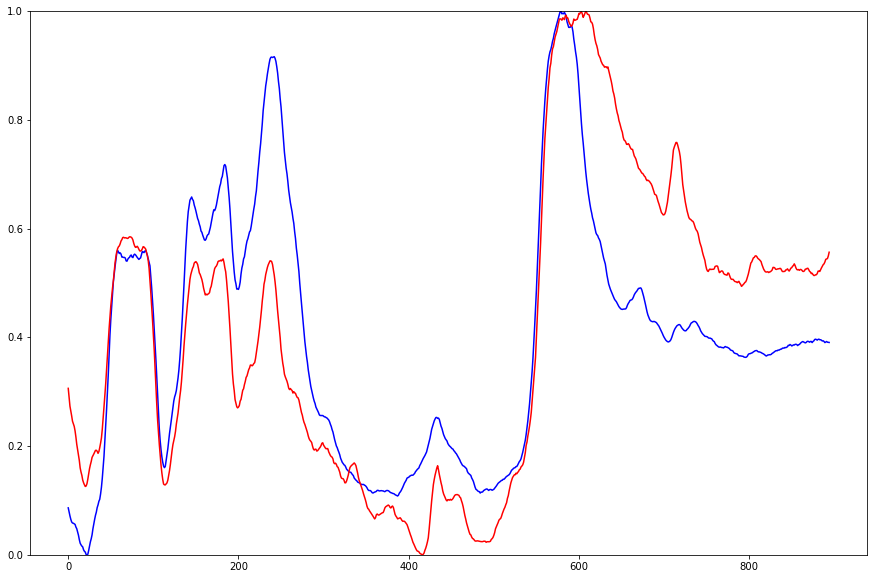

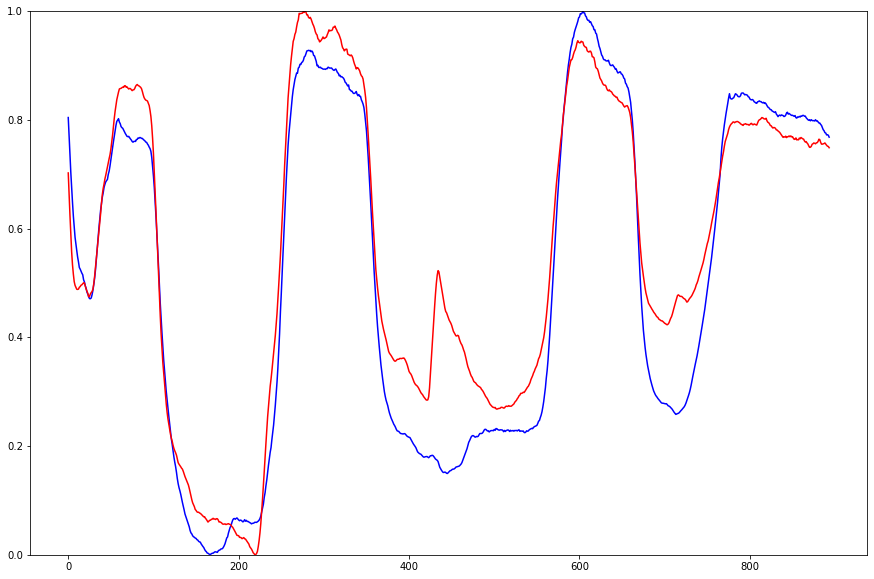

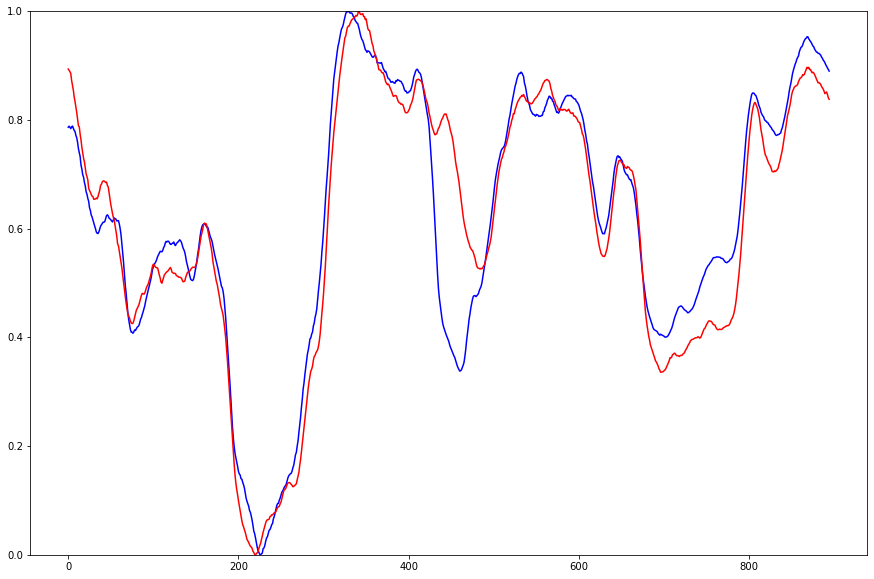

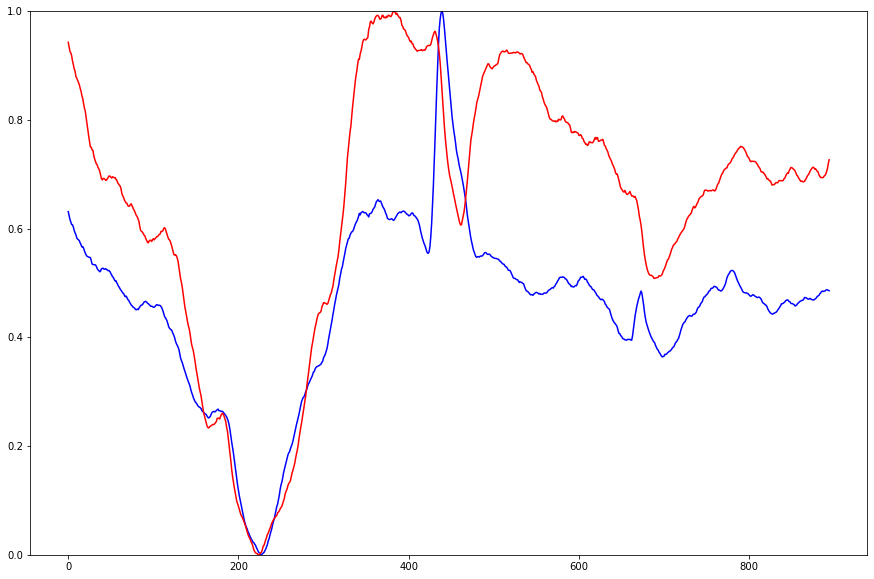

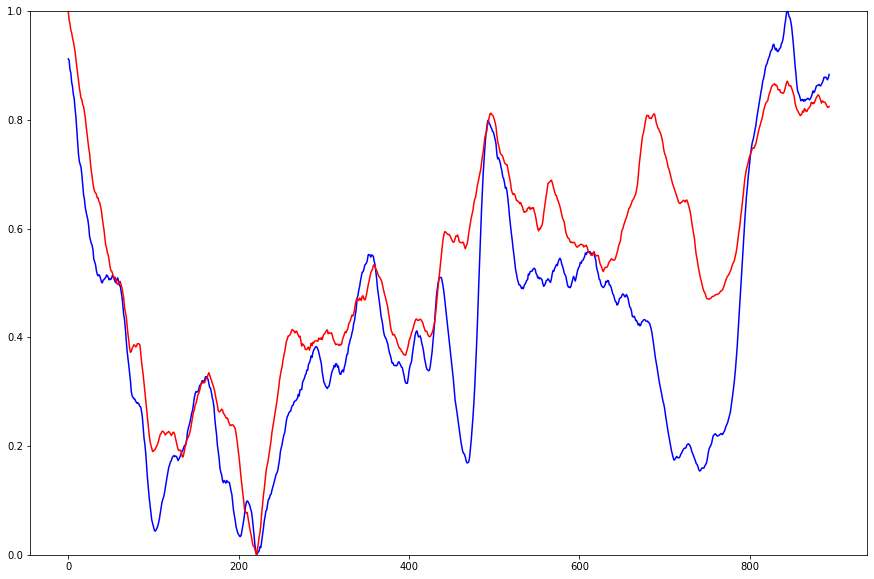

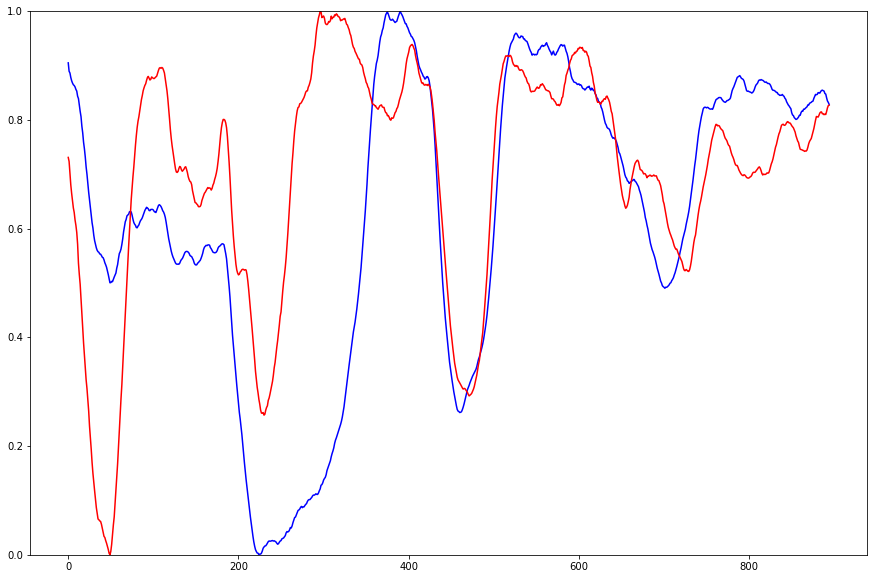

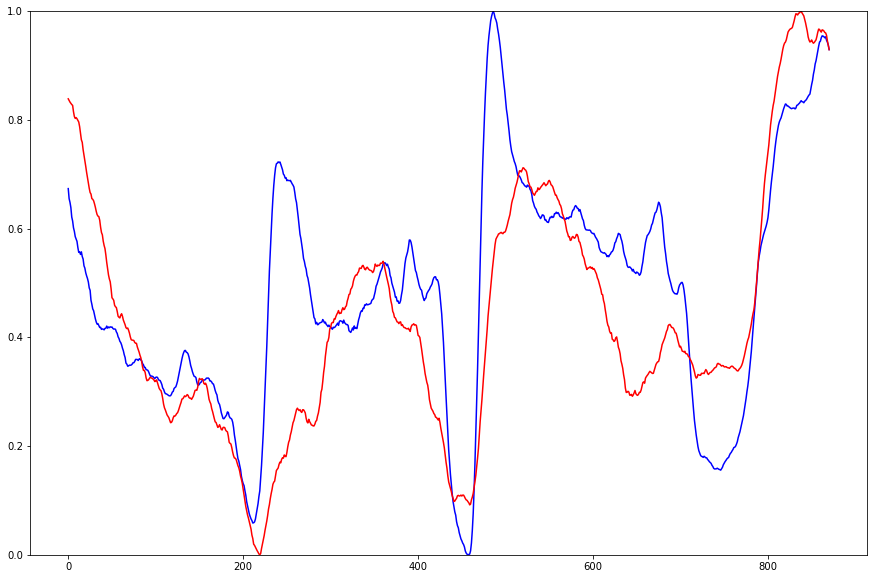

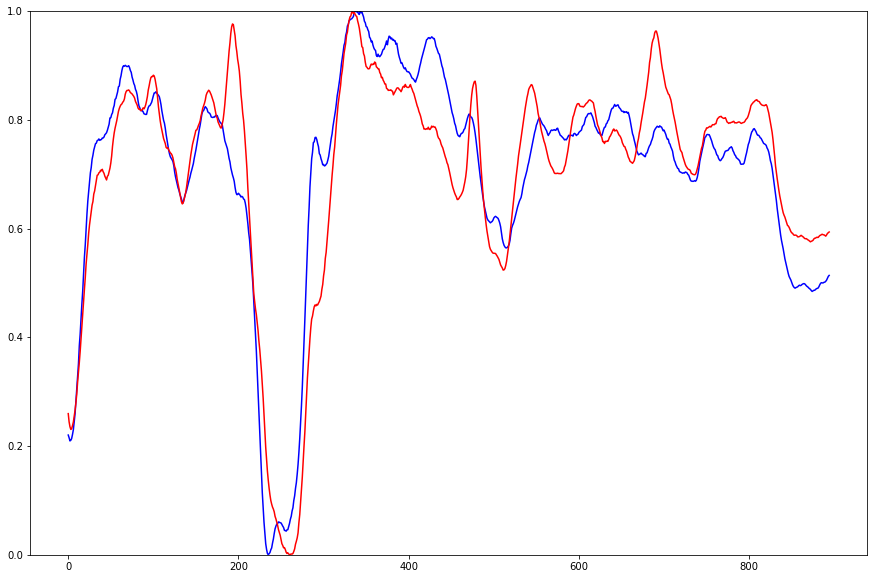

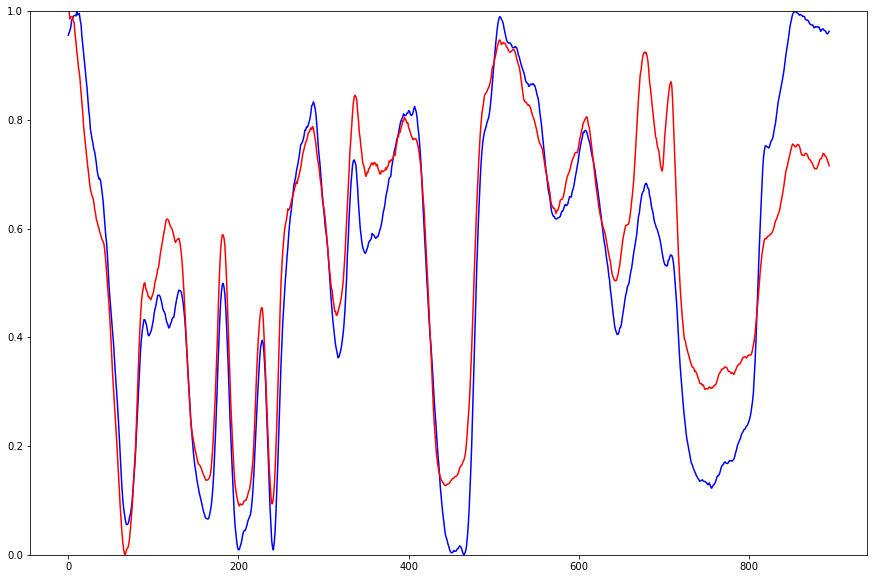

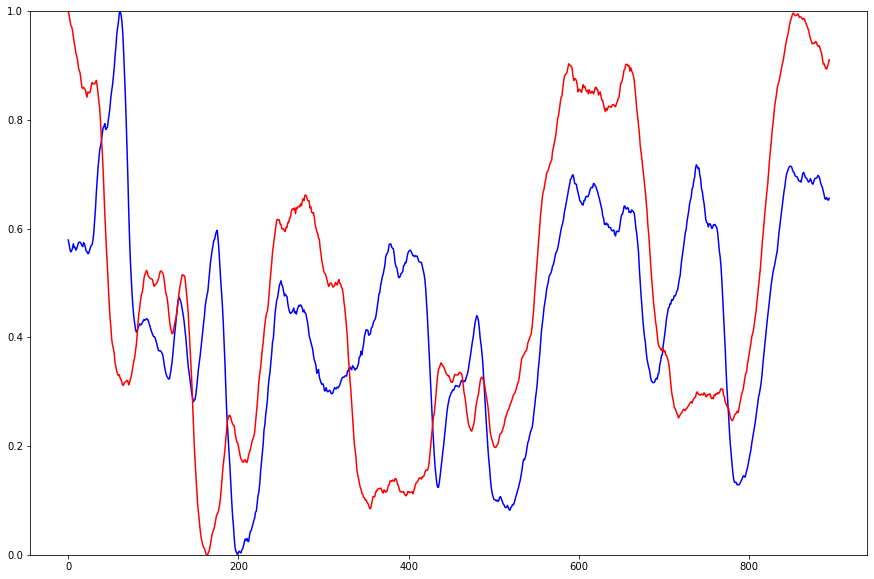

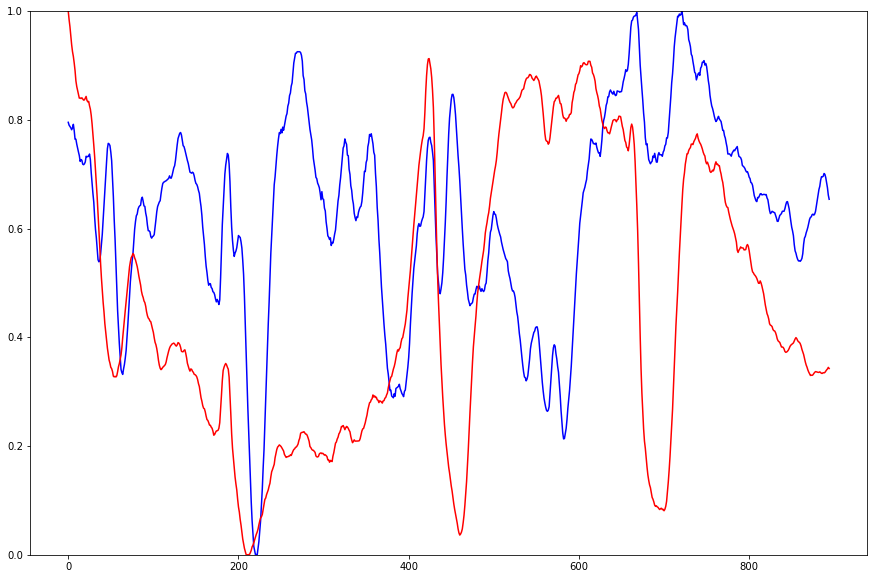

In [5]:
## Need to smooth and normalize data for modeling. Then, look for AIB traces. ##

# There are left and right neuron traces for most neurons in the dataset, 
# so we want to pull out both of them if available 


# Smooth first 

def Smooth(array, shift): # want to smooth data to reduce noise and jitter, I smooth by 5 frames (same as my data)
    step = (2*shift) + 1
    
    temp = []

    for i in range(0,shift):
        plus = array[(i+1):]
        plus = np.append(plus, [np.nan]*(i+1))

        minus = array[:-(i+1)]
        minus = np.insert(minus, 0, [np.nan]*(i+1))

        temp.append(plus)
        temp.append(minus)     

    temp.append(array)

    avg = np.sum((temp), axis = 0) / step
    avgs = avg[shift:-shift]
    
    return avgs


# Normalize smoothed traces
# Note, their dataset has their own version of normalization, but I want to  normalize from 0 - 1 to 
# match our methods

def Norm(array):

    norms = []
    
    mins = np.nanmin(array)
    maxs = np.nanmax(array)
    
    if mins == np.nan and maxs == np.nan:
        norms.append([np.nan]*len(array))
    else:
        for i in array:
            norm = (i - mins)/(maxs - mins)
            norms.append(norm)
    
    return norms


# Search for neurons, and their traces (left and right if applicable)
# Note, you need to kind of know ahead of time whether a neuron has a left/right side, or neither
# I use wormatlas to find out before searching

def LR_Traces(array, searchterm, left_right): #enter neuron search of interest, and side of interest
    
    neuron_number = []
    
    for i in range(0, len(array['neurons'])):
        if searchterm in array['neurons'][i]:
            neuron_number = i
            #print(neuron_number)
    
    if neuron_number == []:
        return 'Error: not found :( '
        # not all worm neurons are present in this dataset - there's 231 out of a total of 302 neurons
    
    traces = array['traces'][neuron_number][0][0]

    L = []
    R = []
    nans = [] # if a neuron doesn't have a left or ride side, it gets saved here

    is_L = array['is_L'][neuron_number][0][0] # checks if neuron is left in neuroPAL
    # data is organized such that a neuron with a left designation has the number 1, right is 0, neither is nan
    # There are 21 worms, so if a neuron has left and right recordings, it actually has 42 arrays

    for i in range(0,len(is_L)):
            trace = traces[i][0][54:-1] #[4:-1] to cut off NaNs, 50 to cut off initial burst that is present
            #(0:(length(traces{neuron}{file})-1))/fps to get the corresponding time in seconds
            if is_L[i] == 1: # left neurons
                try:
                    smoothed = Smooth(trace, 5) # smooth by 5 frames to reduce jitter/noise
                    normalized = Norm(smoothed) # normalize
                    diff_len = 895 - len(normalized) # traces have uneven lengths, want to standardize to same len
                    # chose 895 cuz longest len is 960 - [54:-1] - smoothed (5+5 = 10)
                    L.append(normalized + ([np.nan]*diff_len)) # pad difference in len with nans
                except:
                    L.append([np.nan]*895) # some traces are missing, append nans instead
            if is_L[i] == 0: # right neurons
                try:
                    smoothed = Smooth(trace, 5)
                    normalized = Norm(smoothed)
                    diff_len = 895 - len(normalized)
                    R.append(normalized + ([np.nan]*diff_len))
                except:
                    R.append([np.nan]*895)
            if math.isnan(is_L[i]): # neuron that doesn't have left or right side has nan for is_L
                try:
                    smoothed = Smooth(trace, 5)
                    normalized = Norm(smoothed)
                    diff_len = 895 - len(normalized)
                    nans.append(normalized + ([np.nan]*diff_len))
                except:
                    nans.append([np.nan]*895)
    
    if left_right == 'left':
        return L
    if left_right == 'right':
        return R
    if left_right == 'neither':
        return nans
    
AIB_L = LR_Traces(mat1, 'AIB', 'left')
AIB_R = LR_Traces(mat1, 'AIB', 'right')

# Want to plot just to confirm it was successful
for i in range(worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    ax.plot(AIB_L[i], color='blue')
    ax.plot(AIB_R[i], color='red')
    ax.set_ylim([0,1])


In [6]:
# I looked up all neurons presynaptic to AIB, based on wormwiring.org.
# I manually inputted them here - this took all day :') -tears- lol...
# I separated them based on function, and whether they synapsed onto AIBL or AIBR.

# Note: if the neuron was polymodal with interneuron + sensory/motor, it was not included in the interneuron list 
# Instead they were classified as sensory or motor 
# Command neurons were classified as motor

# Note: I separated them based on function to keep it organized for my own sake of categorizing them, but we 
# end up just combining everything later - if you want to simplify things, just combine them all together here.

# AWC has to be processed separately to designate them as AWC ON or AWC OFF
# from Readme: is_AWCL_OFF = for each file (a), was AWCL stochastically assigned to be AWC-OFF? 
# (otherwise, AWCR is OFF)

AWC_L = LR_Traces(mat1, 'AWC', 'left')
AWC_R = LR_Traces(mat1, 'AWC', 'right')

AWC_OFF = []
AWC_ON = []

for i in range(worm_num):
    if mat1['is_AWCL_OFF'][i][0] == 1:
        AWC_OFF.append(AWC_L[i])
        AWC_ON.append(AWC_R[i])
    else:
        AWC_OFF.append(AWC_R[i])
        AWC_ON.append(AWC_L[i])

## -- Sensory -- ## 
# Sensory neurons presynaptic to AIBL (pre_AIB_sL)
pre_AIB_sL_names = ['ASIL', 'ASGL', 'ASEL', 'ASER', 'ADFL', 'ADFR', 'AFDL', 'AWC_OFF', 'AWC_ON', 'ASKL', 'ASHL', 
                    'ADLL', 'BAGL', 'FLPL']

ASI_L = LR_Traces(mat1, 'ASI', 'left')

ASG_L = LR_Traces(mat1, 'ASG', 'left')

ASE_L = LR_Traces(mat1, 'ASE', 'left')
ASE_R = LR_Traces(mat1, 'ASE', 'right')

ADF_L = LR_Traces(mat1, 'ADF', 'left')
ADF_R = LR_Traces(mat1, 'ADF', 'right')

AFD_L = LR_Traces(mat1, 'AFD', 'left')

ASK_L = LR_Traces(mat1, 'ASK', 'left')

ASH_L = LR_Traces(mat1, 'ASH', 'left')

ADL_L = LR_Traces(mat1, 'ADL', 'left')

BAG_L = LR_Traces(mat1, 'BAG', 'left')

FLP_L = LR_Traces(mat1, 'FLP', 'left')

pre_AIB_sL = np.concatenate((ASI_L, ASG_L, ASE_L, ASE_R, ADF_L, ADF_R, AFD_L, AWC_OFF, AWC_ON, ASK_L, ASH_L, ADL_L, 
                             BAG_L, FLP_L))
    
pre_AIB_sL = np.reshape(pre_AIB_sL,(len(pre_AIB_sL_names),21, 895)) 

# ------ #
# Sensory neurons presynaptic to AIBR (pre_AIB_sR)
pre_AIB_sR_names = ['ASIR', 'ASGR', 'AWBL', 'ASEL', 'ASER', 'ADFL', 'AWC_OFF', 'AWC_ON', 'ASKR', 'ASHR', 'ADLR', 'FLPL']

ASI_R = LR_Traces(mat1, 'ASI', 'right')

ASG_R = LR_Traces(mat1, 'ASG', 'right')

AWB_L = LR_Traces(mat1, 'AWB', 'left')

ASE_L = LR_Traces(mat1, 'ASE', 'left')
ASE_R = LR_Traces(mat1, 'ASE', 'right')

ADF_L = LR_Traces(mat1, 'ADF', 'left')

#AWC_L = LR_Traces(mat1, 'AWC', 'left')
#AWC_R = LR_Traces(mat1, 'AWC', 'right')

ASK_R = LR_Traces(mat1, 'ASK', 'right')

ASH_R = LR_Traces(mat1, 'ASH', 'right')

ADL_R = LR_Traces(mat1, 'ADL', 'right')

FLP_L = LR_Traces(mat1, 'FLP', 'left')

pre_AIB_sR = np.concatenate((ASI_R, ASG_R, AWB_L, ASE_L, ASE_R, ADF_L, AWC_OFF, AWC_ON, ASK_R, ASH_R, ADL_R, FLP_L))
pre_AIB_sR = np.reshape(pre_AIB_sR,(len(pre_AIB_sR_names),21, 895)) 

## -- Interneuron -- ## 
# Interneurons presynaptic to AIBL (pre_AIB_iL)
pre_AIB_iL_names = ['AINR', 'AIYL', 'AIAL', 'AIZL', 'AIZR', 'ADAL', 'ADAR', 'RIBR', 'RIGR', 'AIBL', 'RICR', 
                    'DVC', 'PVT']

AIN_R = LR_Traces(mat1, 'AIN', 'right')

AIY_L = LR_Traces(mat1, 'AIY', 'left')

AIA_L = LR_Traces(mat1, 'AIA', 'left')

AIZ_L = LR_Traces(mat1, 'AIZ', 'left')
AIZ_R = LR_Traces(mat1, 'AIZ', 'right')

ADA_L = LR_Traces(mat1, 'ADA', 'left')
ADA_R = LR_Traces(mat1, 'ADA', 'right')

RIB_R = LR_Traces(mat1, 'RIB', 'right')

RIG_R = LR_Traces(mat1, 'RIG', 'right')

AIB_L = LR_Traces(mat1, 'AIB', 'left')

RIC_R = LR_Traces(mat1, 'RIC', 'right')

DVC = LR_Traces(mat3, 'DVC', 'neither')

PVT = LR_Traces(mat3, 'PVT', 'neither')

pre_AIB_iL = np.concatenate((AIN_R, AIY_L, AIA_L, AIZ_L, AIZ_R, ADA_L, ADA_R, RIB_R, RIG_R, AIB_L, RIC_R, DVC, PVT))
pre_AIB_iL = np.reshape(pre_AIB_iL,(len(pre_AIB_iL_names),21, 895)) 

# ----- #
# Interneurons presynaptic to AIBR (pre_AIB_iR)
pre_AIB_iR_names = ['AIAR', 'AUAL', 'AIZL', 'AIZR', 'ADAL', 'ADAR', 'RIBL', 'RIGL', 'RMGL', 'RICR', 'DVC', 'PVT']

AIA_R = LR_Traces(mat1, 'AIA', 'right')

AUA_L = LR_Traces(mat1, 'AUA', 'left')

AIZ_L = LR_Traces(mat1, 'AIZ', 'left')
AIZ_R = LR_Traces(mat1, 'AIZ', 'right')

ADA_L = LR_Traces(mat1, 'ADA', 'left')
ADA_R = LR_Traces(mat1, 'ADA', 'right')

RIB_L = LR_Traces(mat1, 'RIB', 'left')

RIG_L = LR_Traces(mat1, 'RIG', 'left')

RMG_L = LR_Traces(mat1, 'RMG', 'left')

RIC_R = LR_Traces(mat1, 'RIC', 'right')

DVC = LR_Traces(mat3, 'DVC', 'neither')

PVT = LR_Traces(mat3, 'PVT', 'neither')

pre_AIB_iR = np.concatenate((AIA_R, AUA_L, AIZ_L, AIZ_R, ADA_L, ADA_R, RIB_L, RIG_L, RMG_L, RIC_R, DVC, PVT))
pre_AIB_iR = np.reshape(pre_AIB_iR, (len(pre_AIB_iR_names),21, 895))

## -- Motor -- ##
# Motor neurons presynaptic to AIBL (pre_AIB_mL)
pre_AIB_mL_names = ['SAADL', 'SAADR', 'SAAVL', 'RIML', 'RIMR', 'AVAL', 'AVAR']

SAAD_L = LR_Traces(mat1, 'SAAD', 'left')
SAAD_R = LR_Traces(mat1, 'SAAD', 'right')

SAAV_L = LR_Traces(mat1, 'SAAV', 'left')

RIM_L = LR_Traces(mat1, 'RIM', 'left')
RIM_R = LR_Traces(mat1, 'RIM', 'right')

AVA_L = LR_Traces(mat1, 'AVA', 'left')
AVA_R = LR_Traces(mat1, 'AVA', 'right')

pre_AIB_mL = np.concatenate((SAAD_L, SAAD_R, SAAV_L, RIM_L, RIM_R, AVA_L, AVA_R))
pre_AIB_mL = np.reshape(pre_AIB_mL, (len(pre_AIB_mL_names),21, 895))

# ----- #
# Motor neurons presynaptic to AIBR (pre_AIB_mR)
pre_AIB_mR_names = ['SAADR', 'SAAVR', 'RIML', 'RMHR', 'SMDVR', 'AVAL', 'AVAR']

SAAD_R = LR_Traces(mat1, 'SAAD', 'right')

SAAV_R = LR_Traces(mat1, 'SAAV', 'right')

RIM_L = LR_Traces(mat1, 'RIM', 'left')

RMH_R = LR_Traces(mat1, 'RMH', 'right')

SMDV_R = LR_Traces(mat1, 'SMDV', 'right')

AVA_L = LR_Traces(mat1, 'AVA', 'left')
AVA_R = LR_Traces(mat1, 'AVA', 'right')

pre_AIB_mR = np.concatenate((SAAD_R, SAAV_R, RIM_L, RMH_R, SMDV_R, AVA_L, AVA_R))
pre_AIB_mR = np.reshape(pre_AIB_mR, (len(pre_AIB_mR_names),21, 895))

## -- Gap -- ## 
# These include gap junctions, and are unique neurons that only share gap junctions and 
# no chemical connection to AIB. ie if the neuron had a chemical and gap junction, it was included above, to avoid 
# repeats. I didn't separate neurons based on sensory/interneuron/motor function for simplicity.

# Neurons that share gap junctions with AIBL (pre_AIB_gL)
pre_AIB_gL_names = ['RIS', 'RMED', 'RIVL', 'SMDDR', 'SIADR']

RIS = LR_Traces(mat1, 'RIS', 'neither')

RMED = LR_Traces(mat1, 'RMED', 'neither')

RIV_L = LR_Traces(mat1, 'RIV', 'left')

SMDD_R = LR_Traces(mat1, 'SMDD', 'right')

SIAD_R = LR_Traces(mat1, 'SIAD', 'right')

pre_AIB_gL = np.concatenate((RIS, RMED, RIV_L, SMDD_R, SIAD_R))
pre_AIB_gL = np.reshape(pre_AIB_gL, (len(pre_AIB_gL_names),21, 895))

# ----- #
# Neurons that share gap junctions with AIBR (pre_AIB_gR)
pre_AIB_gR_names = ['AFDR', 'RIS', 'PVPL', 'RICR', 'RIVR', 'SMDDL', 'SIAVL']

AFD_R = LR_Traces(mat1, 'AFD', 'right')

RIS = LR_Traces(mat1, 'RIS', 'neither')

PVP_L = LR_Traces(mat3, 'PVP', 'left')

RIC_R = LR_Traces(mat1, 'RIC', 'right')

RIV_R = LR_Traces(mat1, 'RIV', 'right')

SMDD_L = LR_Traces(mat1, 'SMDD', 'left')

SIAV_L = LR_Traces(mat1, 'SIAV', 'left')

pre_AIB_gR = np.concatenate((AFD_R, RIS, PVP_L, RIC_R, RIV_R, SMDD_L, SIAV_L))
pre_AIB_gR = np.reshape(pre_AIB_gR, (len(pre_AIB_gR_names),21, 895))

print('Done')

Done


In [10]:
#### Combine ALL neurons together ####

# Like I said above, you could simplify above code block to just combine them together. 
# I initially wanted to organize it for another analysis, but ended up not needing it.

temp_pre_AIB_ALL_names_L = pre_AIB_sL_names+pre_AIB_iL_names+pre_AIB_mL_names+pre_AIB_gL_names

temp_pre_AIB_ALL_L = np.concatenate((pre_AIB_sL,pre_AIB_iL,pre_AIB_mL,pre_AIB_gL))

temp_pre_AIB_ALL_names_R = pre_AIB_sR_names+pre_AIB_iR_names+pre_AIB_mR_names+pre_AIB_gR_names

temp_pre_AIB_ALL_R = np.concatenate((pre_AIB_sR,pre_AIB_iR,pre_AIB_mR,pre_AIB_gR))

# Want to remove the duplicates
# -- AIBL -- #
pre_AIB_ALL_names_L = []
pre_AIB_ALL_L = [] 

for i in range(len(temp_pre_AIB_ALL_names_L)): 
    if temp_pre_AIB_ALL_names_L[i] not in pre_AIB_ALL_names_L: 
        pre_AIB_ALL_names_L.append(temp_pre_AIB_ALL_names_L[i]) 
        pre_AIB_ALL_L.append(temp_pre_AIB_ALL_L[i])
        
print('Number of neurons (before duplicates removed) in AIBL list:', len(temp_pre_AIB_ALL_L))
print('Number of neurons (after duplicates removed) in AIBL list:', len(pre_AIB_ALL_L))

# -- AIBR -- #
pre_AIB_ALL_names_R = []
pre_AIB_ALL_R = [] 

for j in range(len(temp_pre_AIB_ALL_names_R)): 
    if temp_pre_AIB_ALL_names_R[j] not in pre_AIB_ALL_names_R: 
        pre_AIB_ALL_names_R.append(temp_pre_AIB_ALL_names_R[j]) 
        pre_AIB_ALL_R.append(temp_pre_AIB_ALL_R[j])
        
print('Number of neurons (before duplicates removed) in AIBR list:', len(temp_pre_AIB_ALL_R))
print('Number of neurons (after duplicates removed) in AIBR list:', len(pre_AIB_ALL_R))

print('Done')


Number of neurons (before duplicates removed) in AIBL list: 39
Number of neurons (after duplicates removed) in AIBL list: 39
Number of neurons (before duplicates removed) in AIBR list: 38
Number of neurons (after duplicates removed) in AIBR list: 37
Done


In [11]:
## Correlate AIB with neurons - I used Pearson's correlation

import numpy.ma as ma

def Correlate(neuron1, neuron2):

    corrs = np.empty((len(neuron1), worm_num)) # make empty array to store correlations
    corrs[:] = np.nan

    for i in range(len(neuron1)):
        for j in range(worm_num):
            corr = ma.corrcoef(ma.masked_invalid(neuron1[i][j]), ma.masked_invalid(neuron2[j]))
            # use mask to help correlation function with nans, otherwise corrcoef doesn't work with nans
            corrs[i][j] = corr[0][1] # index for correlation number
            
    return corrs

corr_pre_AIB_ALL_L = Correlate(pre_AIB_ALL_L, AIB_L)
corr_pre_AIB_ALL_R = Correlate(pre_AIB_ALL_R, AIB_R)

print('Done')

/var/folders/h2/nr_g6r3s37v0y4h9l4yjz0bw0000gn/T/ipykernel_51740/3607250697.py:14: UserWarning: Warning: converting a masked element to nan.
  corrs[i][j] = corr[0][1] # index for correlation number


Done


In [12]:
## Rank neurons based on how well they correlate to AIBL/R activity - rank from highest to lowest ##

def Ranking(array, names): 
    ranked = np.zeros((len(names), worm_num)) #make empty array the shape of (# neurons, 21 worms)
    
    name = []
    medians = []
    true_medians = []
    ranked_meds = []
    absolute_meds = []

    for i in array: # loop through array
        med = np.nanmedian(i) # nanmedian will take the medians and ignore nans
        # we want the median value of the correlation values because medians will exclude weird outliers
        # we also want the medians because each neuron has up to 21 traces for each worm, so we can take the 
        # median of that so that we just have 1 median value per neuron to rank to make things easier
        medians.append(abs(med)) # append the absolute value, because we want the overall highest number 
        # for ranking, regardless of positive/negative; 0 means no correlation
        true_medians.append(med) # these are the real medians, not absolute value, for saving later
        
    sort = np.sort(medians) # sort function sorts numbers from lowest to highest
    reverse_sort = sort[::-1] # here we can reverse that sort list to be highest rank to lowest
    for i in range(len(names)): # loop through all neurons
        where = np.where(reverse_sort[i] == medians)
        # where function is useful for finding the index number. here I want to find where the value of 
        # the reverse_sort ranking matches the values of the absolute medians
        # the reverse_sort is ranked by highest correlation, but the medians list has maintained the order of 
        # the neurons list values, so we want to know where they match to find the index of the neuron value
        # ex: if my highest ranking neuron (reverse_sort[0]) is actually neuron # 97, then I want to know the 
        # index number of 97
        num_where = where[0][0] # the where function is written weird so I'm just reformatting it here
        ranked[i] = (array[num_where]) # now I can save the location of the neuron order to 'ranked'
        name.append(names[num_where]) # and I can also save the name order to match
        ranked_meds.append(true_medians[num_where]) # want to save ranked median values (not absolute values)
        absolute_meds.append(medians[num_where]) # want to save absolute values of meds for comparisons later
        
    return name, ranked, ranked_meds, absolute_meds


rank_pre_ALL_AIB_L = Ranking(corr_pre_AIB_ALL_L, pre_AIB_ALL_names_L)
rank_pre_ALL_AIB_L_names = rank_pre_ALL_AIB_L[0]
rank_pre_ALL_AIB_L_corrs = rank_pre_ALL_AIB_L[1]
rank_pre_ALL_AIB_L_meds = rank_pre_ALL_AIB_L[2]
rank_pre_ALL_AIB_L_absmeds = rank_pre_ALL_AIB_L[3]

rank_pre_ALL_AIB_R = Ranking(corr_pre_AIB_ALL_R, pre_AIB_ALL_names_R)
rank_pre_ALL_AIB_R_names = rank_pre_ALL_AIB_R[0]
rank_pre_ALL_AIB_R_corrs = rank_pre_ALL_AIB_R[1]
rank_pre_ALL_AIB_R_meds = rank_pre_ALL_AIB_R[2]
rank_pre_ALL_AIB_R_absmeds = rank_pre_ALL_AIB_R[3]

print('Done')


Done


/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 81.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


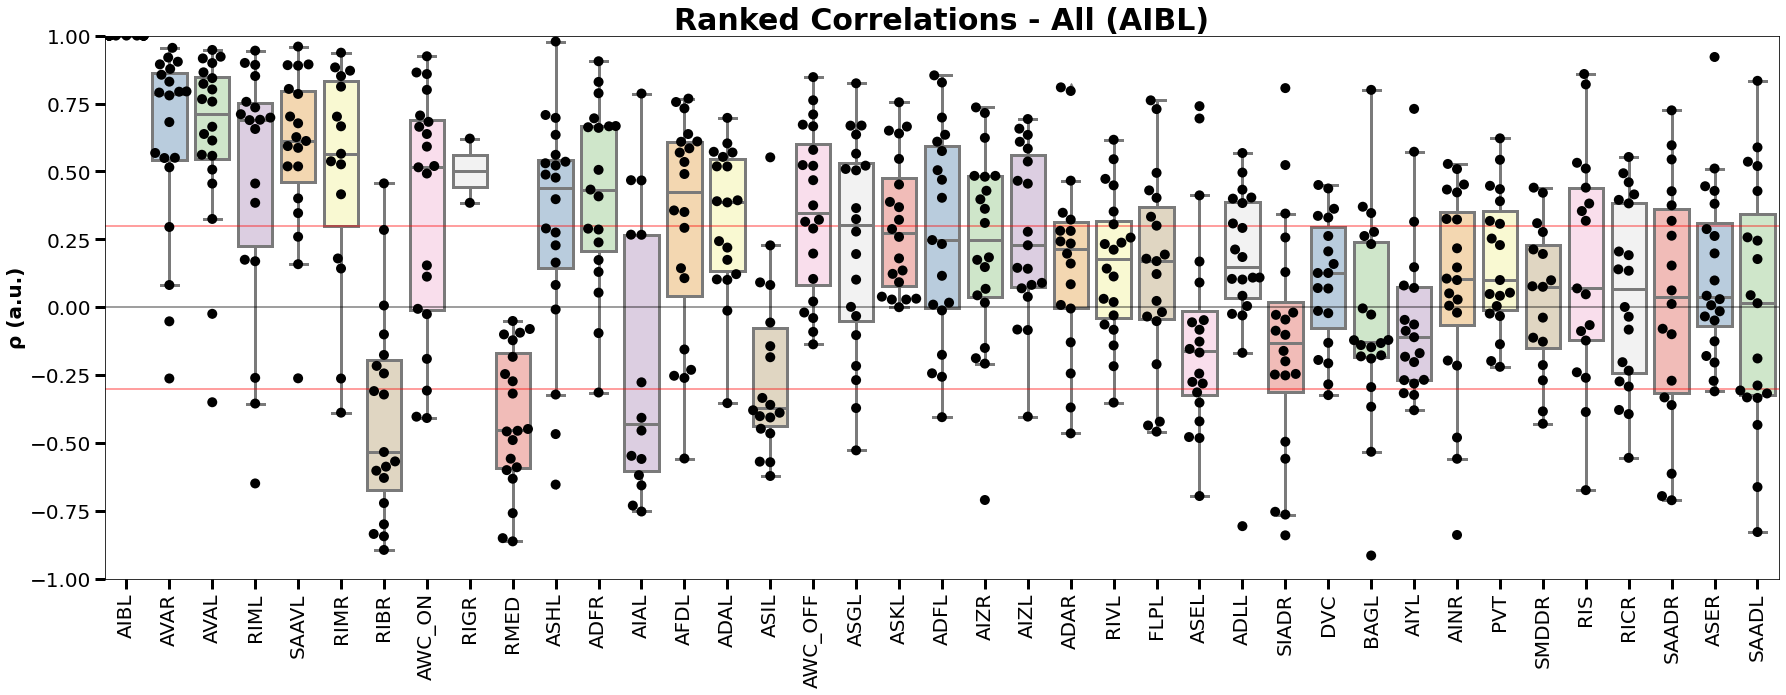

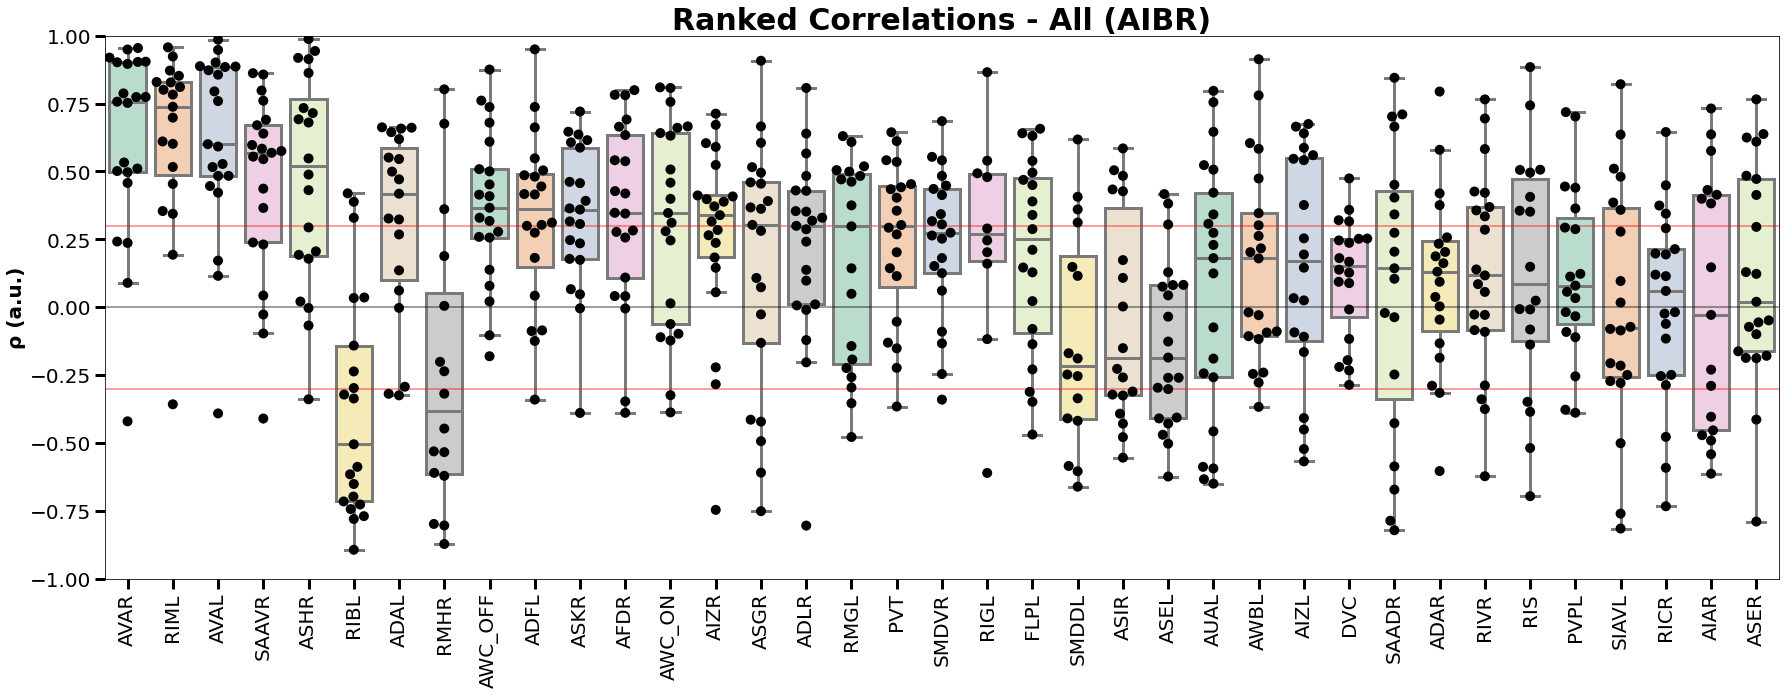

In [13]:
## Plot correlations of all presynaptic inputs

dF_corrsL = pd.DataFrame(np.array(rank_pre_ALL_AIB_L_corrs).T, columns=rank_pre_ALL_AIB_L_names)
dF_corrsR = pd.DataFrame(np.array(rank_pre_ALL_AIB_R_corrs).T, columns=rank_pre_ALL_AIB_R_names)

colors_l = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(30, 10), facecolor='w')
ax.set_title('Ranked Correlations - All (AIBL)', fontsize=30, weight='bold')
sns.boxplot(data=dF_corrsL, palette=colors_l, linewidth = 3)
sns.swarmplot(data=dF_corrsL, color='black', size=10)
plt.xticks(rotation=90)
ax.set_ylabel('ρ (a.u.)', fontsize=20, weight='bold')
ax.tick_params(axis= 'both', labelsize=20, length=10, width=3)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
plt.axhline(y=-0.3, color='red', alpha=0.5)
plt.axhline(y=0.3, color='red', alpha=0.5)
#plt.savefig('Ranked Correlations - All - AIBL.svg')

colors_r = sns.color_palette("Pastel2")

fig, ax = plt.subplots(1,1, figsize=(30, 10), facecolor='w')
ax.set_title('Ranked Correlations - All (AIBR)', fontsize=30, weight='bold')
sns.boxplot(data=dF_corrsR, palette=colors_r, linewidth = 3)
sns.swarmplot(data=dF_corrsR, color='black', size=10)
plt.xticks(rotation=90)
ax.set_ylabel('ρ (a.u.)', fontsize=20, weight='bold')
ax.tick_params(axis= 'both', labelsize=20, length=10, width=3)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
plt.axhline(y=-0.3, color='red', alpha=0.5)
plt.axhline(y=0.3, color='red', alpha=0.5)
#plt.savefig('Ranked Correlations - All - AIBR.svg')


In [14]:
# Want only the neurons with relevant correlations, so cut off lower ranking inputs

# Make sure you're using absolute values of medians! (_absmeds)

cutoff = 0.3 
# I chose 0.3 arbitratily, too high and it cut off too many neurons. too low and didn't cut off enough

## -- AIBL -- ##
indexL = []

for i in range(len(rank_pre_ALL_AIB_L_absmeds)):
    if rank_pre_ALL_AIB_L_absmeds[i] < cutoff: # if absolute value of medians below cutoff, save index
        print('Low ranking:', rank_pre_ALL_AIB_L_names[i]) # print low ranking inputs
        indexL.append(i) # save index

print('Index numbers of low ranking inputs:', indexL)

indexL = indexL[0] # just need first number as cutoff because it's already sorted by rank

top_rank_pre_ALL_AIB_L_names = rank_pre_ALL_AIB_L_names[:indexL] # use index# to cutoff and save rest of inputs
top_rank_pre_ALL_AIB_L_corrs = rank_pre_ALL_AIB_L_corrs[:indexL]
         
print('Inputs before cutoff:', rank_pre_ALL_AIB_L_names)
print('Inputs after cutoff:', top_rank_pre_ALL_AIB_L_names)

print('Number of inputs before cutoff:', len(rank_pre_ALL_AIB_L_corrs))
print('Number of inputs after cutoff:', len(top_rank_pre_ALL_AIB_L_corrs))

## -- AIBR -- ##
indexR = []

for i in range(len(rank_pre_ALL_AIB_R_absmeds)):
    if rank_pre_ALL_AIB_R_absmeds[i] < cutoff: # if absolute value of medians below cutoff, save index
        print('Low ranking:', rank_pre_ALL_AIB_R_names[i]) # print low ranking inputs
        indexR.append(i) # save index

print('Index numbers of low ranking inputs:', indexR)

indexR = indexR[0] # just need first number as cutoff because it's already sorted by rank

top_rank_pre_ALL_AIB_R_names = rank_pre_ALL_AIB_R_names[:indexR] # use index# to cutoff and save rest of inputs
top_rank_pre_ALL_AIB_R_corrs = rank_pre_ALL_AIB_R_corrs[:indexR]
         
print('Inputs before cutoff:',rank_pre_ALL_AIB_R_names)
print('Inputs after cutoff:', top_rank_pre_ALL_AIB_R_names)

print('Number of inputs before cutoff:', len(rank_pre_ALL_AIB_R_corrs))
print('Number of inputs after cutoff:', len(top_rank_pre_ALL_AIB_R_corrs))

print('Done')


Low ranking: ASKL
Low ranking: ADFL
Low ranking: AIZR
Low ranking: AIZL
Low ranking: ADAR
Low ranking: RIVL
Low ranking: FLPL
Low ranking: ASEL
Low ranking: ADLL
Low ranking: SIADR
Low ranking: DVC
Low ranking: BAGL
Low ranking: AIYL
Low ranking: AINR
Low ranking: PVT
Low ranking: SMDDR
Low ranking: RIS
Low ranking: RICR
Low ranking: SAADR
Low ranking: ASER
Low ranking: SAADL
Index numbers of low ranking inputs: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Inputs before cutoff: ['AIBL', 'AVAR', 'AVAL', 'RIML', 'SAAVL', 'RIMR', 'RIBR', 'AWC_ON', 'RIGR', 'RMED', 'ASHL', 'ADFR', 'AIAL', 'AFDL', 'ADAL', 'ASIL', 'AWC_OFF', 'ASGL', 'ASKL', 'ADFL', 'AIZR', 'AIZL', 'ADAR', 'RIVL', 'FLPL', 'ASEL', 'ADLL', 'SIADR', 'DVC', 'BAGL', 'AIYL', 'AINR', 'PVT', 'SMDDR', 'RIS', 'RICR', 'SAADR', 'ASER', 'SAADL']
Inputs after cutoff: ['AIBL', 'AVAR', 'AVAL', 'RIML', 'SAAVL', 'RIMR', 'RIBR', 'AWC_ON', 'RIGR', 'RMED', 'ASHL', 'ADFR', 'AIAL', 'AFDL', 'ADAL', 'ASIL', 'AWC

/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 61.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


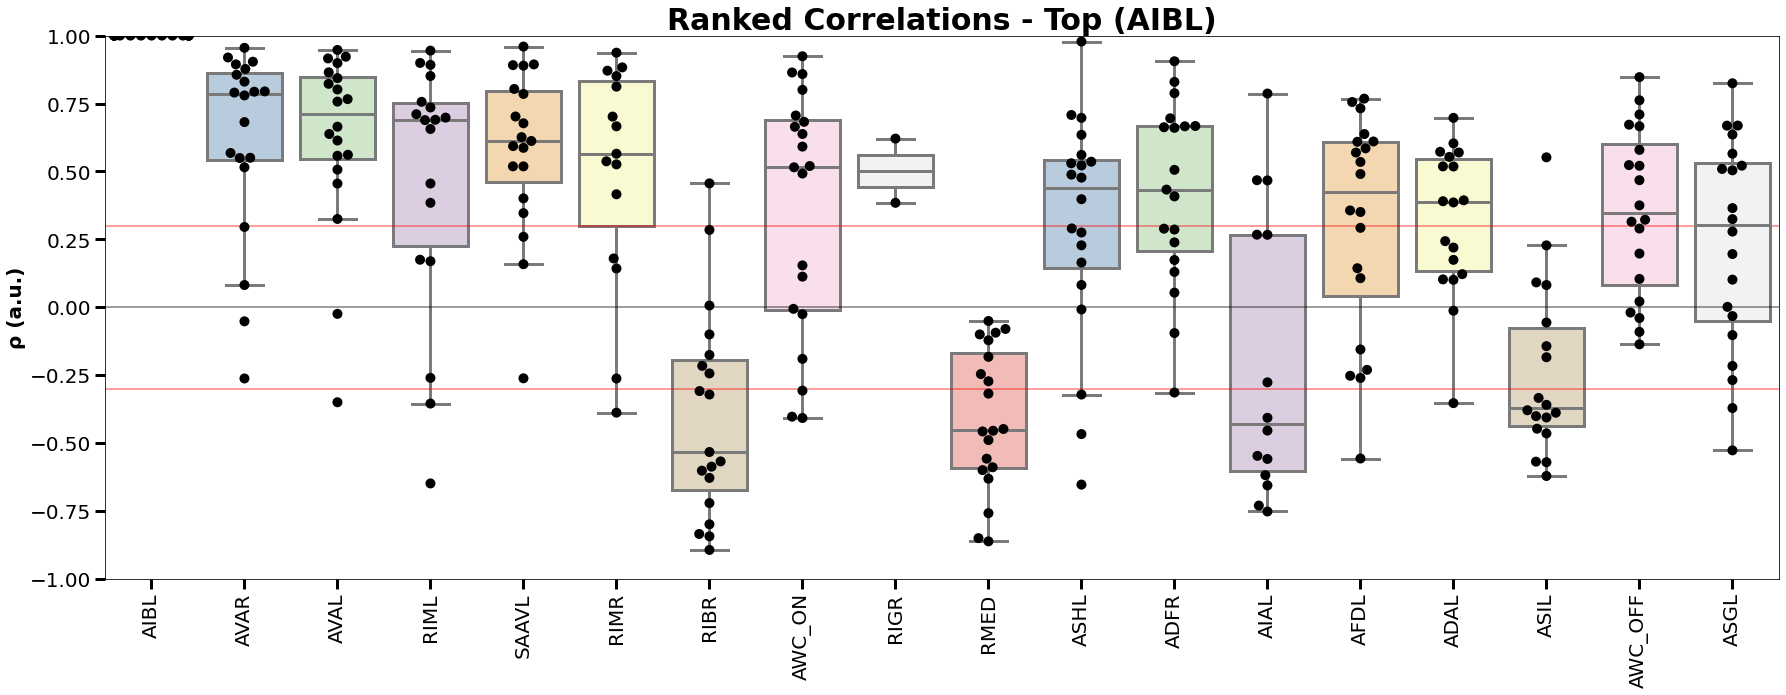

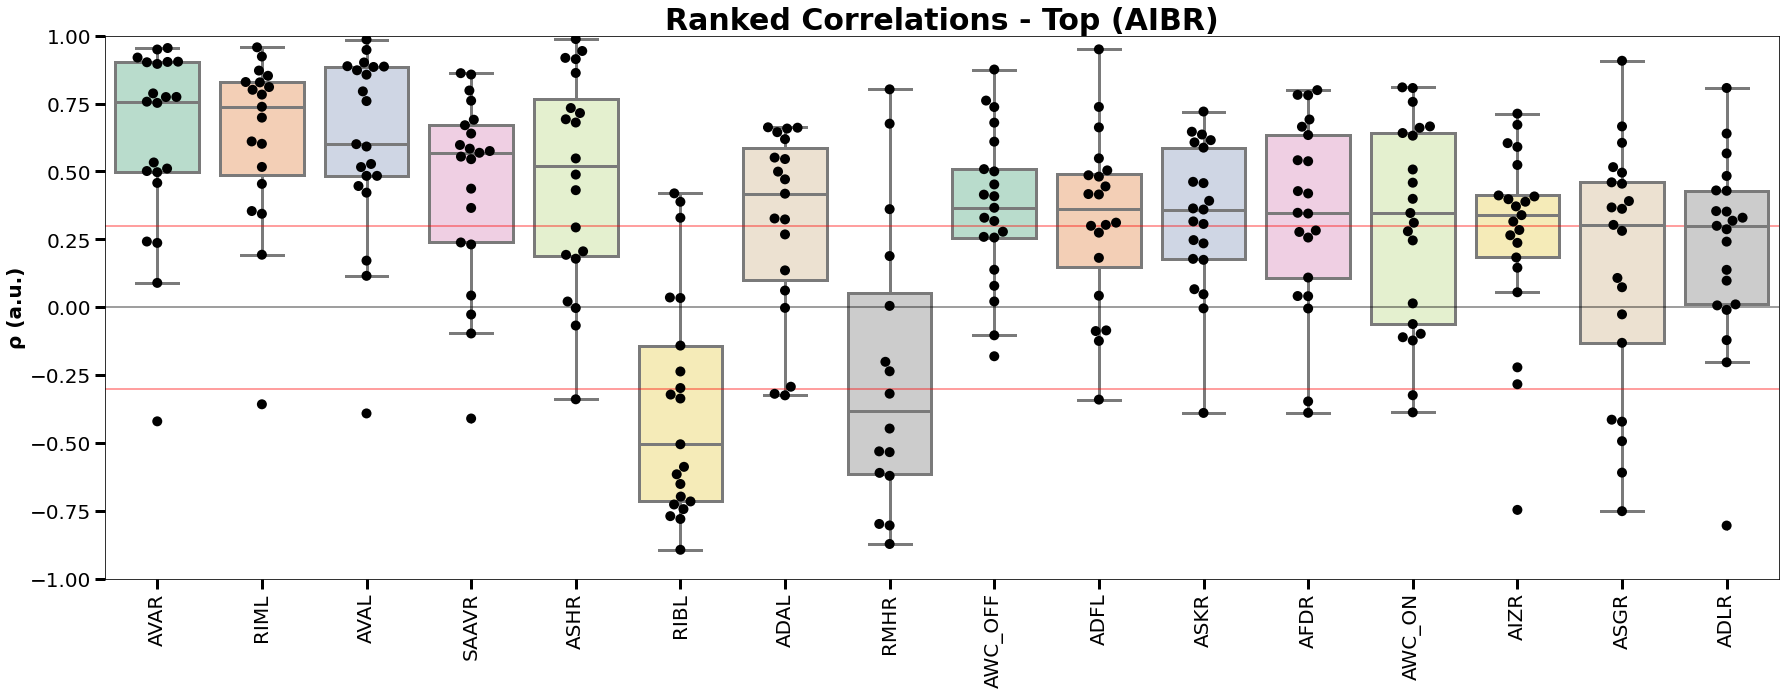

In [15]:
## Plot ranked correlations -- just inputs with correlations above/below +/- 0.3

dF_topL = pd.DataFrame(np.array(top_rank_pre_ALL_AIB_L_corrs).T, columns=top_rank_pre_ALL_AIB_L_names)
dF_topR = pd.DataFrame(np.array(top_rank_pre_ALL_AIB_R_corrs).T, columns=top_rank_pre_ALL_AIB_R_names)

colors_l = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(30, 10), facecolor='w')
ax.set_title('Ranked Correlations - Top (AIBL)', fontsize=30, weight='bold')
sns.boxplot(data=dF_topL, palette=colors_l, linewidth = 3)
sns.swarmplot(data=dF_topL, color='black', size=10)
plt.xticks(rotation=90)
ax.set_ylabel('ρ (a.u.)', fontsize=20, weight='bold')
ax.tick_params(axis= 'both', labelsize=20, length=10, width=3)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
plt.axhline(y=-0.3, color='red', alpha=0.5)
plt.axhline(y=0.3, color='red', alpha=0.5)
#plt.savefig('Ranked Correlations - Top - AIBL.svg')

colors_r = sns.color_palette("Pastel2")

fig, ax = plt.subplots(1,1, figsize=(30, 10), facecolor='w')
ax.set_title('Ranked Correlations - Top (AIBR)', fontsize=30, weight='bold')
sns.boxplot(data=dF_topR, palette=colors_r, linewidth = 3)
sns.swarmplot(data=dF_topR, color='black', size=10)
plt.xticks(rotation=90)
ax.set_ylabel('ρ (a.u.)', fontsize=20, weight='bold')
ax.tick_params(axis= 'both', labelsize=20, length=10, width=3)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
plt.axhline(y=-0.3, color='red', alpha=0.5)
plt.axhline(y=0.3, color='red', alpha=0.5)
#plt.savefig('Ranked Correlations - Top - AIBR.svg')


In [16]:
# Some of the pre-synaptic inputs have very little trials, want to exclude those

## -- AIBL -- ##
new_rank_pre_ALL_AIB_L_corrs = []
new_rank_pre_ALL_AIB_L_names = []

for k in range(len(top_rank_pre_ALL_AIB_L_corrs)):
    counter = 0 # set counter
    for l in top_rank_pre_ALL_AIB_L_corrs[k]:
        if math.isnan(l) == True: # if trace is missing, will have nans
            counter += 1 # count the nans
    if counter > 10:
        # 10 was chosen arbitrarily; since there's 21 worms total, 10 seemed like a good amount (half)
        print('Less than 10 traces', top_rank_pre_ALL_AIB_L_names[k])
    else:
        # if more than 10 traces per worm, save this data
        new_rank_pre_ALL_AIB_L_corrs.append(top_rank_pre_ALL_AIB_L_corrs[k])
        new_rank_pre_ALL_AIB_L_names.append(top_rank_pre_ALL_AIB_L_names[k])

print('Inputs before excluding low-trial numbers', top_rank_pre_ALL_AIB_L_names)
print('Inputs after excluding low-trial numbers', new_rank_pre_ALL_AIB_L_names)

print('Inputs before excluding low-trial numbers', len(top_rank_pre_ALL_AIB_L_corrs))
print('Inputs after excluding low-trial numbers', len(new_rank_pre_ALL_AIB_L_corrs))


## -- AIBR -- ##
new_rank_pre_ALL_AIB_R_corrs = []
new_rank_pre_ALL_AIB_R_names = []

for i in range(len(top_rank_pre_ALL_AIB_R_corrs)):
    counter = 0
    for j in top_rank_pre_ALL_AIB_R_corrs[i]:
        if math.isnan(j) == True:
            counter += 1
    if counter > 10: 
        # also chosen arbitrarily; since there's 21 worms total, 10 seemed like a good amount (half)
        print('Less than 10 traces',top_rank_pre_ALL_AIB_R_names[i])
    else:
        new_rank_pre_ALL_AIB_R_corrs.append(top_rank_pre_ALL_AIB_R_corrs[i])
        new_rank_pre_ALL_AIB_R_names.append(top_rank_pre_ALL_AIB_R_names[i])

print('Inputs before excluding low-trial numbers', top_rank_pre_ALL_AIB_R_names)
print('Inputs after excluding low-trial numbers', new_rank_pre_ALL_AIB_R_names)

print('Inputs before excluding low-trial numbers', len(top_rank_pre_ALL_AIB_R_corrs))
print('Inputs after excluding low-trial numbers', len(new_rank_pre_ALL_AIB_R_corrs))

print('Done')


Less than 10 traces RIGR
Inputs before excluding low-trial numbers ['AIBL', 'AVAR', 'AVAL', 'RIML', 'SAAVL', 'RIMR', 'RIBR', 'AWC_ON', 'RIGR', 'RMED', 'ASHL', 'ADFR', 'AIAL', 'AFDL', 'ADAL', 'ASIL', 'AWC_OFF', 'ASGL']
Inputs after excluding low-trial numbers ['AIBL', 'AVAR', 'AVAL', 'RIML', 'SAAVL', 'RIMR', 'RIBR', 'AWC_ON', 'RMED', 'ASHL', 'ADFR', 'AIAL', 'AFDL', 'ADAL', 'ASIL', 'AWC_OFF', 'ASGL']
Inputs before excluding low-trial numbers 18
Inputs after excluding low-trial numbers 17
Inputs before excluding low-trial numbers ['AVAR', 'RIML', 'AVAL', 'SAAVR', 'ASHR', 'RIBL', 'ADAL', 'RMHR', 'AWC_OFF', 'ADFL', 'ASKR', 'AFDR', 'AWC_ON', 'AIZR', 'ASGR', 'ADLR']
Inputs after excluding low-trial numbers ['AVAR', 'RIML', 'AVAL', 'SAAVR', 'ASHR', 'RIBL', 'ADAL', 'RMHR', 'AWC_OFF', 'ADFL', 'ASKR', 'AFDR', 'AWC_ON', 'AIZR', 'ASGR', 'ADLR']
Inputs before excluding low-trial numbers 16
Inputs after excluding low-trial numbers 16
Done


In [17]:
"""# Now want to take the ranked and excluded list with only relevant neurons and get those corresponding traces

ranked_tracesL = []

for i in range(len(pre_AIB_ALL_names_L)):
    if pre_AIB_ALL_names_L[i] in new_rank_pre_ALL_AIB_L_names:
        #print(i)
        ranked_tracesL.append(pre_AIB_ALL_L[i])

#print(pre_AIB_ALL_names_L)
print(len(new_rank_pre_ALL_AIB_L_names))
print(len(ranked_tracesL))

ranked_tracesR = []

for i in range(len(pre_AIB_ALL_names_R)):
    if pre_AIB_ALL_names_R[i] in new_rank_pre_ALL_AIB_R_names:
        #print(i)
        ranked_tracesR.append(pre_AIB_ALL_R[i])

#print(pre_AIB_ALL_names_L)
print(len(new_rank_pre_ALL_AIB_R_names))
print(len(ranked_tracesR))"""

'# Now want to take the ranked and excluded list with only relevant neurons and get those corresponding traces\n\nranked_tracesL = []\n\nfor i in range(len(pre_AIB_ALL_names_L)):\n    if pre_AIB_ALL_names_L[i] in new_rank_pre_ALL_AIB_L_names:\n        #print(i)\n        ranked_tracesL.append(pre_AIB_ALL_L[i])\n\n#print(pre_AIB_ALL_names_L)\nprint(len(new_rank_pre_ALL_AIB_L_names))\nprint(len(ranked_tracesL))\n\nranked_tracesR = []\n\nfor i in range(len(pre_AIB_ALL_names_R)):\n    if pre_AIB_ALL_names_R[i] in new_rank_pre_ALL_AIB_R_names:\n        #print(i)\n        ranked_tracesR.append(pre_AIB_ALL_R[i])\n\n#print(pre_AIB_ALL_names_L)\nprint(len(new_rank_pre_ALL_AIB_R_names))\nprint(len(ranked_tracesR))'

/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 61.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


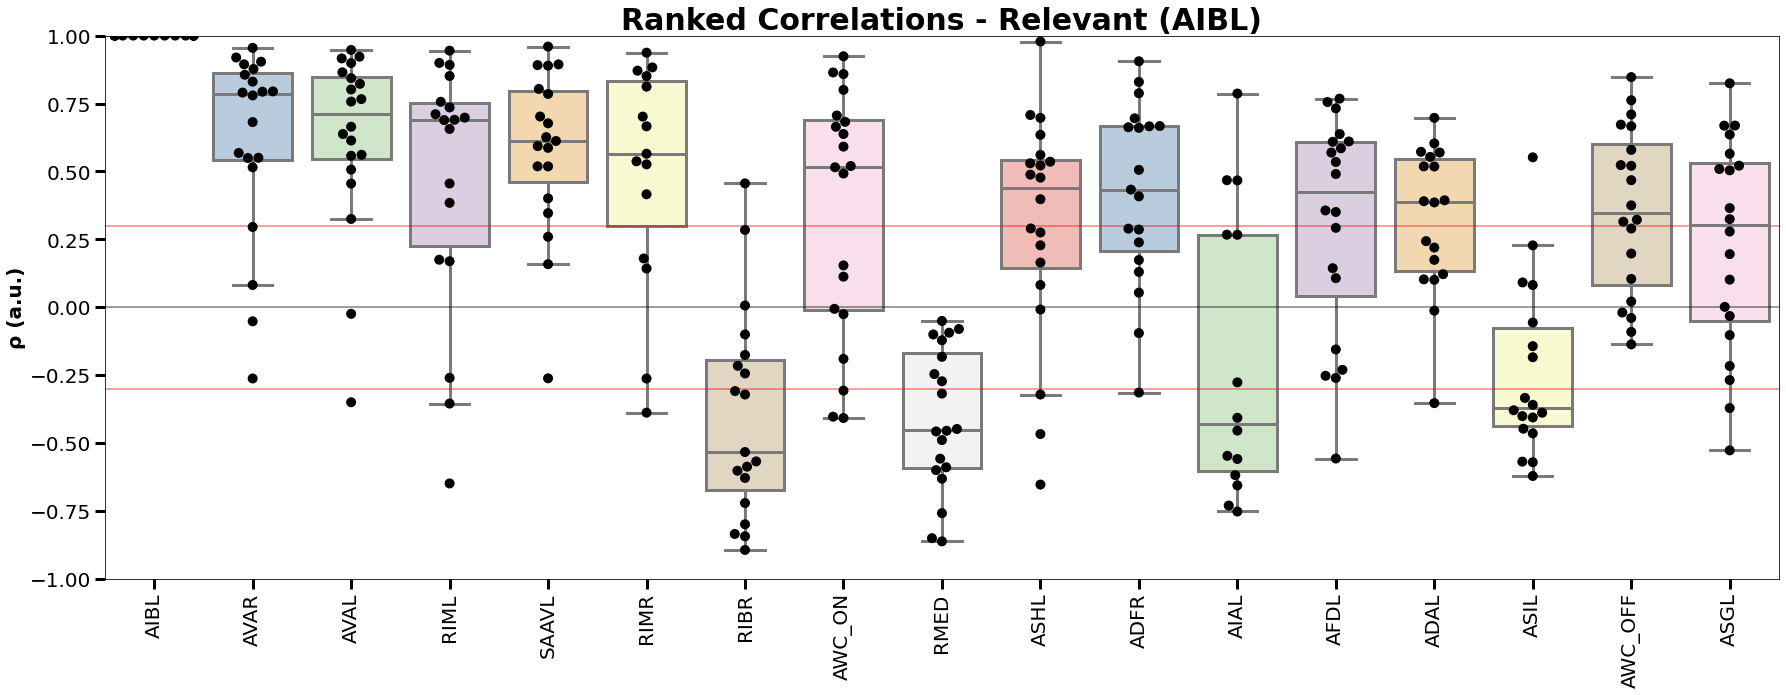

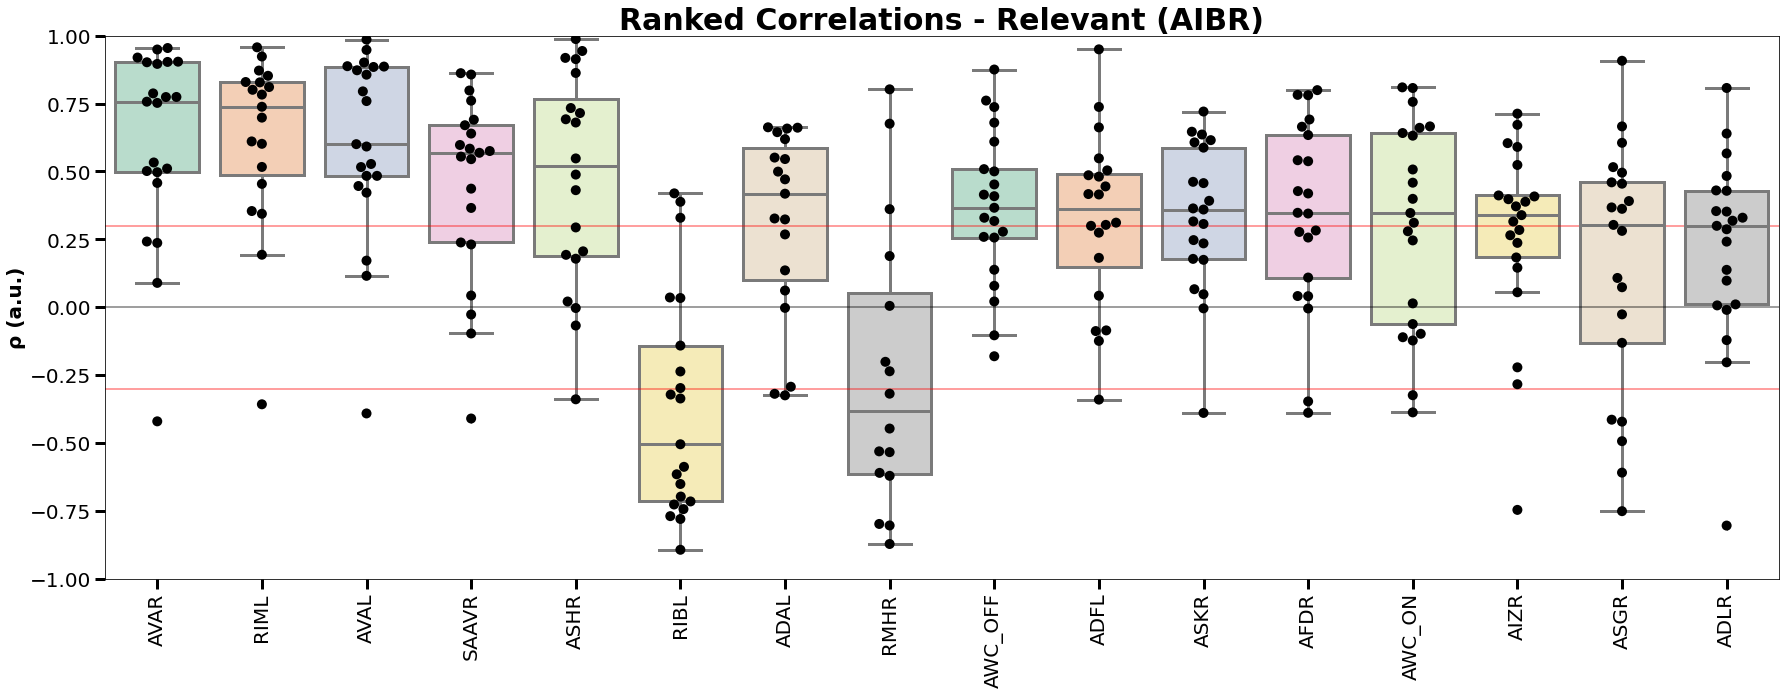

In [18]:
## Finally, plot our ranked correlations that are top ranking and low trial numbers excluded
# Going to just call it 'relevant' for short

dF_relevantL = pd.DataFrame(np.array(new_rank_pre_ALL_AIB_L_corrs).T, columns=new_rank_pre_ALL_AIB_L_names)
dF_relevantR = pd.DataFrame(np.array(new_rank_pre_ALL_AIB_R_corrs).T, columns=new_rank_pre_ALL_AIB_R_names)

colors_l = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(30, 10), facecolor='w')
ax.set_title('Ranked Correlations - Relevant (AIBL)', fontsize=30, weight='bold')
sns.boxplot(data=dF_relevantL, palette=colors_l, linewidth = 3)
sns.swarmplot(data=dF_relevantL, color='black', size=10)
plt.xticks(rotation=90)
ax.set_ylabel('ρ (a.u.)', fontsize=20, weight='bold')
ax.tick_params(axis= 'both', labelsize=20, length=10, width=3)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
plt.axhline(y=-0.3, color='red', alpha=0.5)
plt.axhline(y=0.3, color='red', alpha=0.5)
#plt.savefig('Ranked Correlations - Relevant- AIBL.svg')

colors_r = sns.color_palette("Pastel2")

fig, ax = plt.subplots(1,1, figsize=(30, 10), facecolor='w')
ax.set_title('Ranked Correlations - Relevant (AIBR)', fontsize=30, weight='bold')
sns.boxplot(data=dF_relevantR, palette=colors_r, linewidth = 3)
sns.swarmplot(data=dF_relevantR, color='black', size=10)
plt.xticks(rotation=90)
ax.set_ylabel('ρ (a.u.)', fontsize=20, weight='bold')
ax.tick_params(axis= 'both', labelsize=20, length=10, width=3)
ax.set_ylim([-1,1])
plt.axhline(y=0, color='black', alpha=0.5)
plt.axhline(y=-0.3, color='red', alpha=0.5)
plt.axhline(y=0.3, color='red', alpha=0.5)
#plt.savefig('Ranked Correlations - Relevant - AIBR.svg')



In [ ]:
# Then I took this list and went back to my categorized list and looked at what functions 
# (sensory, interneuron, motor) these top correlated/relevant inputs had.